In [1]:
from sae_core.analysis import SAEAnalyzer
from sae_core.pretrained import PRETRAINED_SAES, list_pretrained, load_pretrained
from sae_core.data_processing.textbook_process import load_processed_data
from transformer_lens import HookedTransformer
import numpy as np

In [2]:
# qwen3_06B_l12_resid_file_path = list_pretrained()[-1]
qwen3_06B_l12_resid_file_path = 'qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01'
qwen3_06B_12_resid_SAE, history = load_pretrained(qwen3_06B_l12_resid_file_path, load_history=True)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

qwen3_06B.blocks.12.hook_resid_post.sae.(…):   0%|          | 0.00/33.6M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

history.json: 0.00B [00:00, ?B/s]

In [9]:
history.keys(), history['sparsity'], history['loss']

(dict_keys(['loss', 'recon_loss', 'l1_loss', 'sparsity', 'recon_contribution', 'l1_contribution', 'total_post_layer_mse', 'block_mse_contribution', '13_mse', '14_mse', '15_mse', '16_mse', '17_mse', '18_mse', '19_mse', '20_mse', '21_mse', '22_mse', '23_mse', '24_mse', '25_mse', '26_mse', '27_mse', 'logit_kl', 'kl_contribution']),
 [606.6405410766602,
  212.80902099609375,
  150.66685843467712,
  117.46527945995331,
  93.9050966501236,
  76.1744384765625,
  62.425498247146606,
  53.51434963941574,
  46.09653294086456,
  41.389449059963226],
 [86.80772787332535,
  20.413801103830338,
  17.35943114757538,
  14.509779572486877,
  10.914146944880486,
  7.888857364654541,
  5.7253468334674835,
  4.422265104949474,
  3.668664935976267,
  3.2783272340893745])

In [10]:
qwen3_06B = HookedTransformer.from_pretrained("qwen3-0.6b")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model qwen3-0.6b into HookedTransformer


In [11]:
chemistry_texts = load_processed_data('sae_core/data/processed_data/processed_physics_10_ch.json')

In [12]:
chemistry_texts[500:510]

['# Strategy',
 'Draw a sketch. We draw the acceleration vector in the direction opposite the velocity vector because the plane is decelerating.',
 'FIGURE 2.27',
 '# Solution',
 '1. Identify the knowns.  ,  ,  .',
 '2. Identify the unknown. In this case, it is final velocity,  .',
 '3. Determine which equation to use. We can calculate the final velocity using the equation  .',
 '4. Plug in the known values and solve.',
 '# Discussion',
 'The final velocity is much less than the initial velocity, as desired when slowing down, but still positive. With jet engines, reverse thrust could be maintained long enough to stop the plane and start moving it backward. That would be indicated by a negative final velocity, which is not the case here.']

In [7]:
hook_layer = '12'
hook_name = 'hook_resid_post'
qwen3_analyzer = SAEAnalyzer(qwen3_06B, qwen3_06B_l12_resid_file_path, hook_layer, hook_name, chemistry_texts)

✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01.physics10.exp8
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 8192
✓ Dataset: 4249 texts


In [8]:
qwen3_analyzer.hook_point

'blocks.12.hook_resid_post'

In [9]:
# Check:
print(f"Encoder bias mean: {qwen3_analyzer.sae.b_enc.mean()}")
print(f"Decoder bias norm: {qwen3_analyzer.sae.b_dec.norm()}")

print(f"Encoder weight mean: {qwen3_analyzer.sae.W_enc.mean()}")
print(f"Decoder weight norm: {qwen3_analyzer.sae.W_dec.norm()}")

Encoder bias mean: -0.029307490214705467
Decoder bias norm: 1.8450887203216553
Encoder weight mean: 0.0002031234180321917
Decoder weight norm: 90.5096664428711


In [10]:
np.sqrt(qwen3_06B.cfg.d_model *16)

128.0

In [11]:
paragraph_lengths = [len(par) for par in chemistry_texts]
lower_quartile = np.quantile(paragraph_lengths, 0.25)
upper_quartile = np.quantile(paragraph_lengths, 0.75)
mean = np.mean(paragraph_lengths)
median = np.median(paragraph_lengths)
lower_quartile, upper_quartile, mean, median

(31.0, 343.0, 240.99882325253, 129.0)

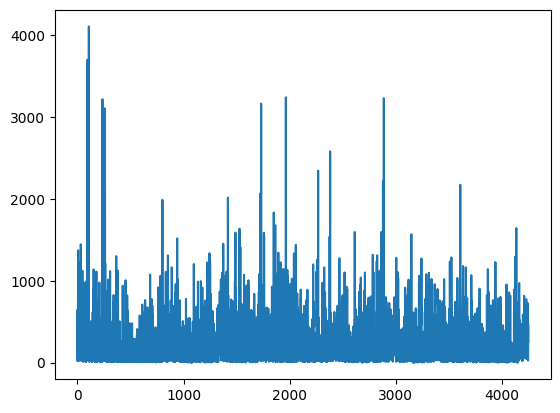

In [12]:
import matplotlib.pyplot as plt
plt.plot(paragraph_lengths)

In [13]:
large_text_list = [par for  par in chemistry_texts if len(par)>mean]
len(large_text_list)

1488

In [14]:
print(f"Dataset size: {len(large_text_list[48:64])}")
for i, text in enumerate(large_text_list[48:64]):
    print(f"Text {i}: len={len(text)}, preview={text[:50]}")

Dataset size: 16
Text 0: len=954, preview=The SI unit for length is the meter (abbreviated m
Text 1: len=992, preview=The SI unit for mass is the kilogram (abbreviated 
Text 2: len=403, preview=Electric current and its accompanying unit, the am
Text 3: len=249, preview=SI units are part of the metric system. The metric
Text 4: len=768, preview=Metric systems have the advantage that conversions
Text 5: len=595, preview=The term order of magnitude refers to the scale of
Text 6: len=506, preview=The fundamental units described in this chapter ar
Text 7: len=693, preview=The standard for length was once based on the wave
Text 8: len=969, preview=<table><tr><td rowspan=1 colspan=7>Prefix Symbol  
Text 9: len=3697, preview=<table><tr><td rowspan=1 colspan=7>Prefix Symbol  
Text 10: len=310, preview=The vastness of the universe and the breadth over 
Text 11: len=478, preview=FIGURE 1.19 Tiny phytoplankton swims among crystal
Text 12: len=410, preview=It is often necessary to convert from one 

In [15]:
# 1. Are activations centered properly?
import torch
tokens = large_text_list[0]
with torch.no_grad():
    _, cache = qwen3_06B.run_with_cache(tokens)
    acts = cache['blocks.14.hook_mlp_out']
    print(f"Activation mean: {acts.mean():.4f}")
    print(f"Activation std: {acts.std():.4f}")
    print(f"Activation range: [{acts.min():.4f}, {acts.max():.4f}]")

# 2. Check decoder norm during training
print(f"Decoder Frobenius norm: {torch.norm(qwen3_06B_12_resid_SAE.W_dec):.4f}")
print(f"Expected: {np.sqrt(qwen3_06B_12_resid_SAE.cfg.d_sae):.4f}")

# 3. Check if features are actually sparse
features = qwen3_06B_12_resid_SAE.encode(acts.flatten(0, 1).to(qwen3_06B_12_resid_SAE.device))
print(f"Feature sparsity: {(features == 0).float().mean():.4f}")  # Should be >0.9
print(f"L0 (features/token): {(features > 0).float().sum(dim=1).mean():.2f}")

Activation mean: -0.0009
Activation std: 0.4103
Activation range: [-6.8404, 7.3667]
Decoder Frobenius norm: 90.4922
Expected: 90.5097
Feature sparsity: 0.3254
L0 (features/token): 5526.64


Final epoch metrics:
  Loss: 1.5221
  Recon Loss: 0.3047
  L1 Loss: 0.0267
  Sparsity (L0): 38.27


/tmp/ipykernel_13056/3042681595.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


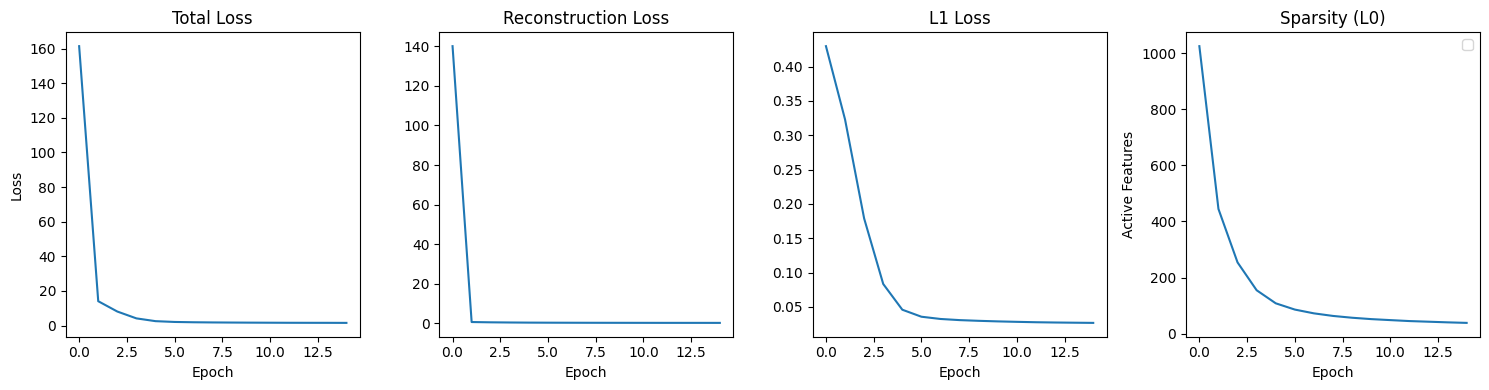

In [16]:
import matplotlib.pyplot as plt

# Load your training history
print(f"Final epoch metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Recon Loss: {history['recon_loss'][-1]:.4f}")
print(f"  L1 Loss: {history['l1_loss'][-1]:.4f}")
print(f"  Sparsity (L0): {history['sparsity'][-1]:.2f}")

# Plot training curves
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 4, 2)
plt.plot(history['recon_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(history['sparsity'])
# plt.axhline(y=100, color='g', linestyle='--', label='Target ~100')
# plt.axhline(y=50, color='b', linestyle='--', label='Good <50')
plt.title('Sparsity (L0)')
plt.xlabel('Epoch')
plt.ylabel('Active Features')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
analyzer = SAEAnalyzer(
    model=qwen3_06B,
    sae_path=qwen3_06B_l12_resid_file_path,
    layer=12,
    hook_name='hook_resid_post',
    dataset=large_text_list
)

results = analyzer.run_full_analysis(
    batch_size=8,
    save_path='analysis_results.json'
)

# Find interesting examples
examples = analyzer.find_max_activating_examples(feature_idx=100, top_k=10)

✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01.physics10.exp8
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 8192
✓ Dataset: 1488 texts

Running Full SAE Analysis


[1/4] Computing Sparsity Metrics...
Computing sparsity metrics on 1488 texts...


Sparsity: 100%|██████████| 186/186 [00:36<00:00,  5.10it/s]



✓ Sparsity Results:
  L0: 71.20 ± 189.16 features/token
  L1: 141.1533 ± 473.4737
  Tokens processed: 357232

[2/4] Identifying Dead Features...

✓ Dead Features (threshold=0.001):
  2254/8192 (27.5%) dead features

[3/4] Computing Reconstruction Metrics...
Computing reconstruction metrics on 1488 texts...


Reconstruction: 100%|██████████| 186/186 [00:36<00:00,  5.07it/s]



✓ Reconstruction Results:
  MSE: 0.346216
  Explained Variance: 0.9984 (99.84%)
  Cosine Similarity: 0.9202
  Tokens processed: 357232

[4/4] Running Ablation Study...
Running ablation study on 1488 texts...


Ablation: 100%|██████████| 372/372 [01:50<00:00,  3.37it/s]



✓ Ablation Study Results:
  Baseline Loss:      2.7731
  Zero Ablation:      11.9312 (+9.1581)
  SAE Reconstruction: 2.9222 (+0.1491)
  Loss Recovered:     98.37%
  Batches processed:  372

✓ Results saved to analysis_results.json

Analysis Complete!

Finding max activating examples for feature 100...


Max Act: 100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


✓ Found top 10 activating examples for feature 100
  Max activation: 14.5619
  Min activation (in top-k): 5.7380


In [23]:
examples

[{'text': '<|im_end|>The ballistocardiograph (BCG) was a diagnostic tool used',
  'target_token': 'ardi',
  'activation': 14.561932563781738,
  'position': 5,
  'batch_idx': 1100},
 {'text': ' due to heart beats is the “ballistocardiograph.” What physics principle(s) are involved here',
  'target_token': 'ardi',
  'activation': 12.59427261352539,
  'position': 95,
  'batch_idx': 579},
 {'text': 'recall Newton’s third law). A ballistocardiograph is a device that can measure this reaction force',
  'target_token': 'ardi',
  'activation': 12.298065185546875,
  'position': 77,
  'batch_idx': 1100},
 {'text': ' blood passing from the heart. However, the electrocardiogram (ECG or EKG) and',
  'target_token': 'card',
  'activation': 11.177844047546387,
  'position': 141,
  'batch_idx': 1100},
 {'text': ' (inversely) on the diameter of the axon (nerve fiber). If the nerve cell',
  'target_token': ' ax',
  'activation': 9.841863632202148,
  'position': 32,
  'batch_idx': 248},
 {'text': ' passi

In [19]:
results.keys()

dict_keys(['sparsity', 'feature_freq', 'dead_features', 'reconstruction', 'ablation'])

In [20]:
results['sparsity']

{'l0_mean': 71.19680767680387,
 'l0_std': 189.16221470510405,
 'l1_mean': 141.15328702705804,
 'l1_std': 473.4737452056373,
 'n_features': 8192,
 'n_tokens': 357232}

In [21]:
results['ablation']

{'baseline_loss': 2.773143518355585,
 'zero_ablation_loss': 11.931214499217207,
 'sae_reconstruction_loss': 2.922223191748383,
 'loss_recovered': 0.9837214983696521,
 'n_batches': 372}

In [22]:
qwen3_06B.cfg.d_model

1024